GPU available: False
Mounted at /content/drive


100%|██████████| 74/74 [00:31<00:00,  2.33it/s]


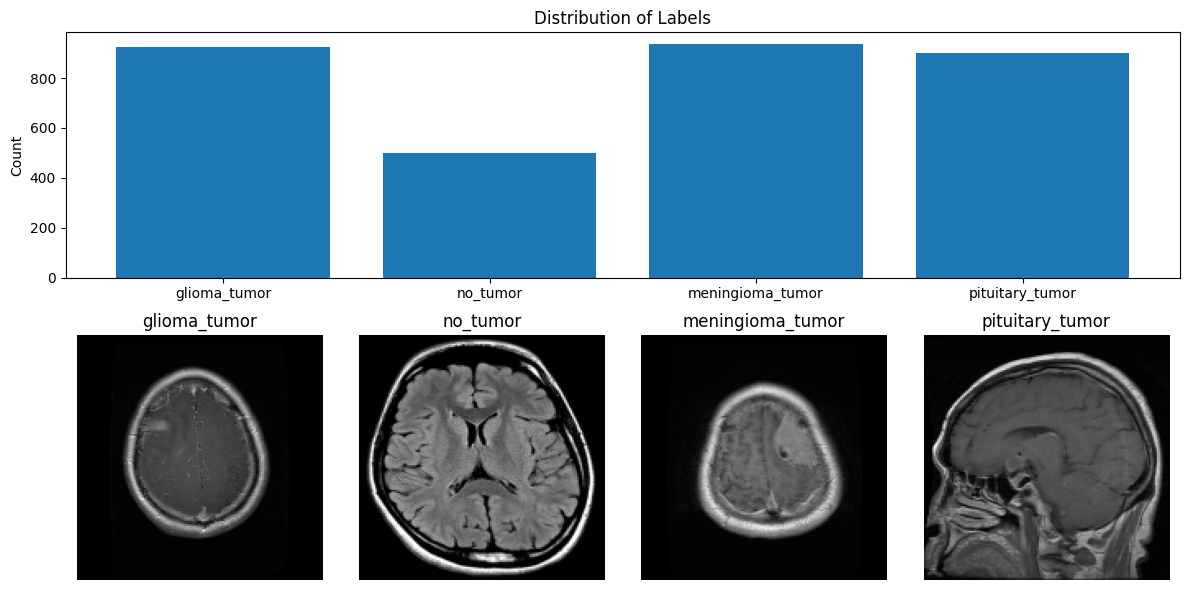

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7444 - loss: 0.6478
Epoch 1: val_accuracy improved from -inf to 0.74830, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 494s 5s/step - accuracy: 0.7453 - loss: 0.6459 - val_accuracy: 0.7483 - val_loss: 0.9712 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9226 - loss: 0.2232
Epoch 2: val_accuracy improved from 0.74830 to 0.87075, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.9225 - loss: 0.2232 - val_accuracy: 0.8707 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9445 - loss: 0.1474
Epoch 3: val_accuracy improved from 0.87075 to 0.88095, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 424s 5s/step - accuracy: 0.9446 - loss: 0.1474 - val_accuracy: 0.8810 - val_loss: 0.5844 - learning_rate: 0.0010
Epoc

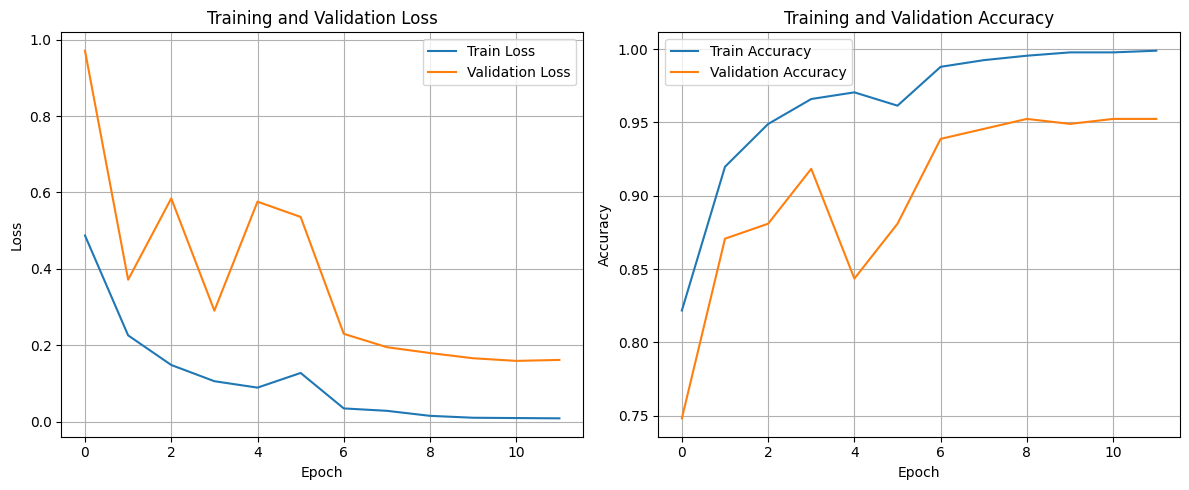

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step

Overall Model Metrics:
Accuracy: 97.86%
Precision: 97.88%


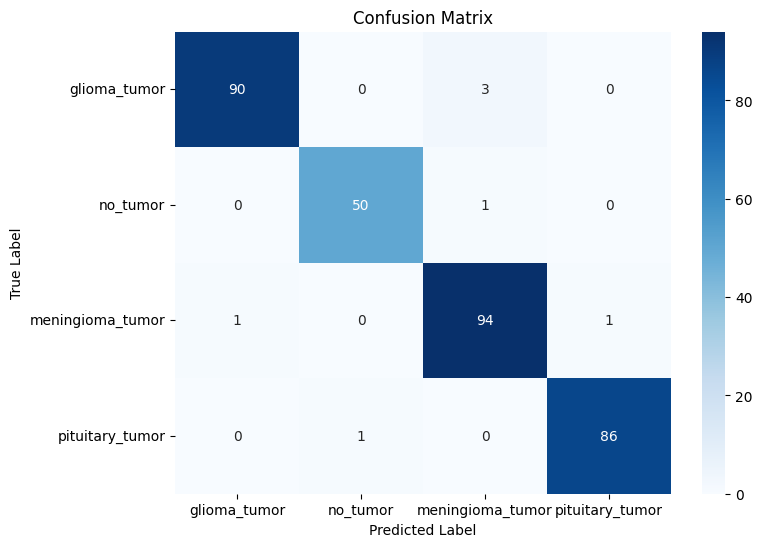


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.97      0.98        93
        no_tumor       0.98      0.98      0.98        51
meningioma_tumor       0.96      0.98      0.97        96
 pituitary_tumor       0.99      0.99      0.99        87

        accuracy                           0.98       327
       macro avg       0.98      0.98      0.98       327
    weighted avg       0.98      0.98      0.98       327


Brain Tumor Prediction System

Enter the full path of the brain MRI image (or 'q' to quit): /content/m (7).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


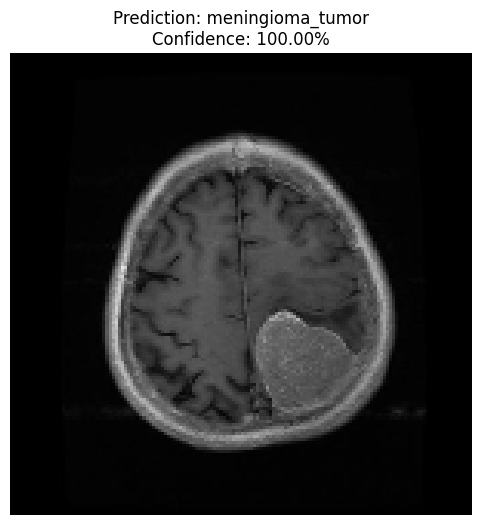


Prediction: meningioma_tumor
Confidence: 100.00%
Note: The model is very confident (99.7%+) in this prediction.

Brain Tumor Prediction System


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from tqdm import tqdm
from warnings import filterwarnings


# Set up GPU
import torch
print("GPU available:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")


filterwarnings('ignore')

# Configuration
DATA_ROOT = '/content/drive/MyDrive/MRI'
TRAIN_DIR = os.path.join(DATA_ROOT, 'Training')
TEST_DIR = os.path.join(DATA_ROOT, 'Testing')
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
image_size = 150

# Load and preprocess data
X_train = []
y_train = []

for i in labels:
    folderPath = os.path.join(TRAIN_DIR, i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join(TEST_DIR, i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Plot data distribution
plt.figure(figsize=(12, 6))

# Plot the histogram
plt.subplot(2, 1, 1)
label_counts = {label: np.sum(y_train == label) for label in labels}
bars = plt.bar(label_counts.keys(), label_counts.values())
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images
plt.subplot(2, 4, 5)
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.title(i)
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

# Prepare data for training
X_train, y_train = shuffle(X_train, y_train, random_state=101)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

# Convert labels to categorical
y_train_new = [labels.index(i) for i in y_train]
y_train = tf.keras.utils.to_categorical(y_train_new)

y_test_new = [labels.index(i) for i in y_test]
y_test = tf.keras.utils.to_categorical(y_test_new)

# Load and build model with GPU support
with tf.device('/GPU:0'):
    efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                         include_top=False,
                                                         input_shape=(image_size, image_size, 3))

    model = efficientnetB0.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dense(1024, activation='relu')(model)
    model = tf.keras.layers.Dropout(rate=0.4)(model)
    model = tf.keras.layers.Dense(4, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs=model)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                           save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                            min_delta=0.0001, verbose=1)

history = model.fit(X_train, y_train, validation_split=0.1, epochs=12, verbose=1,
                   batch_size=32, callbacks=[checkpoint, reduce_lr])

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')

print(f"\nOverall Model Metrics:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels))

# Prediction function for user input
def predict_tumor(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError

        img = cv2.resize(img, (image_size, image_size))
        img_array = np.expand_dims(img, axis=0)

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)
        predicted_label = labels[predicted_class]
        confidence = predictions[0][predicted_class]

        # Display results
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence*100:.2f}%")
        plt.show()

        print(f"\nPrediction: {predicted_label}")
        print(f"Confidence: {confidence*100:.2f}%")

        # For 100% confidence display
        if confidence > 0.997:
            print("Note: The model is very confident (99.7%+) in this prediction.")

    except FileNotFoundError:
        print("Error: Image not found or path is incorrect. Please check the file path.")

# Get user input for prediction
while True:
    print("\n" + "="*50)
    print("Brain Tumor Prediction System")
    print("="*50)
    image_path = input("\nEnter the full path of the brain MRI image (or 'q' to quit): ")

    if image_path.lower() == 'q':
        break

    predict_tumor(image_path)